In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

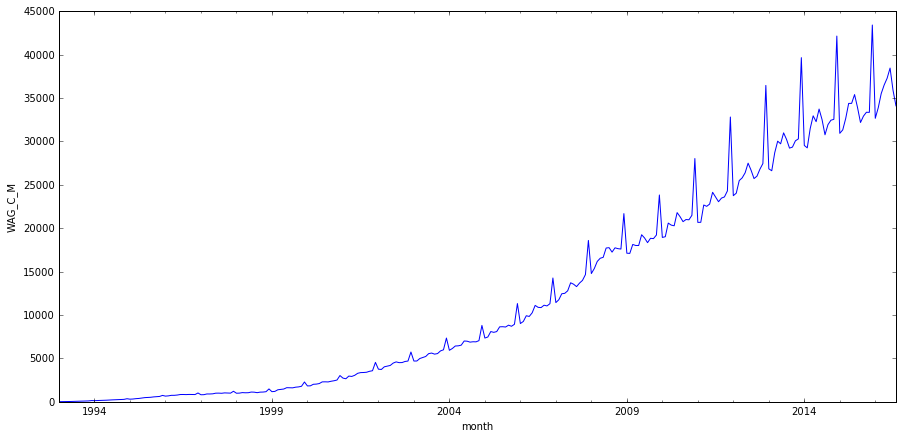

In [3]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('WAG_C_M')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

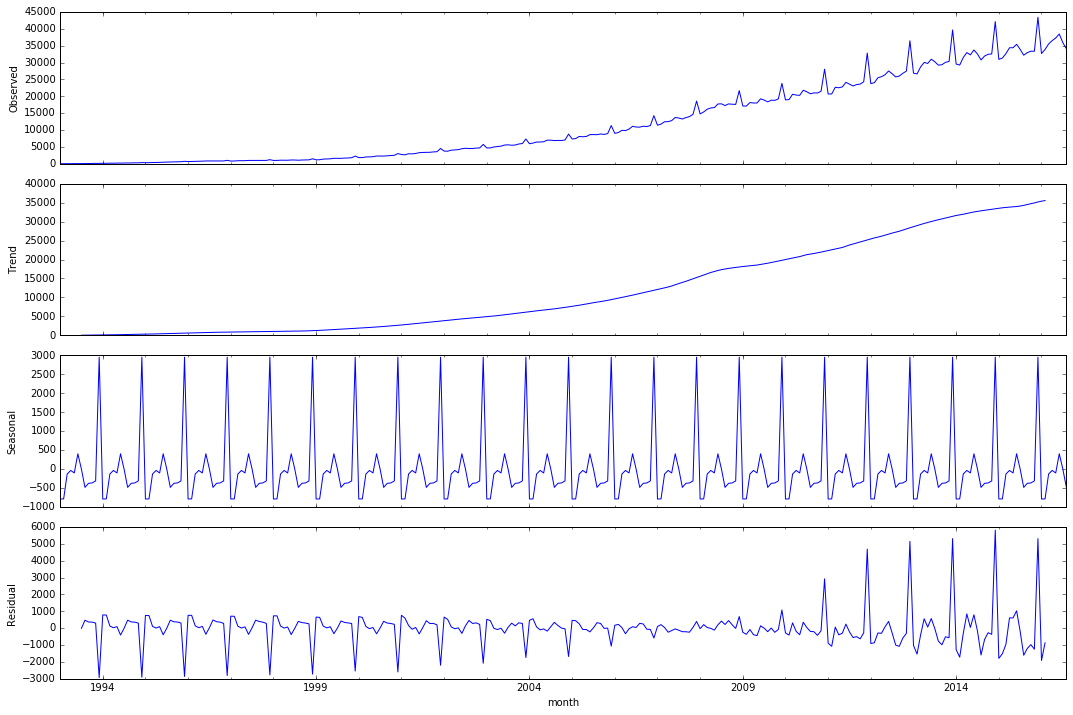

Критерий Дики-Фуллера: p=0.991850


In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
pylab.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

### Стабилизация дисперси

применим преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


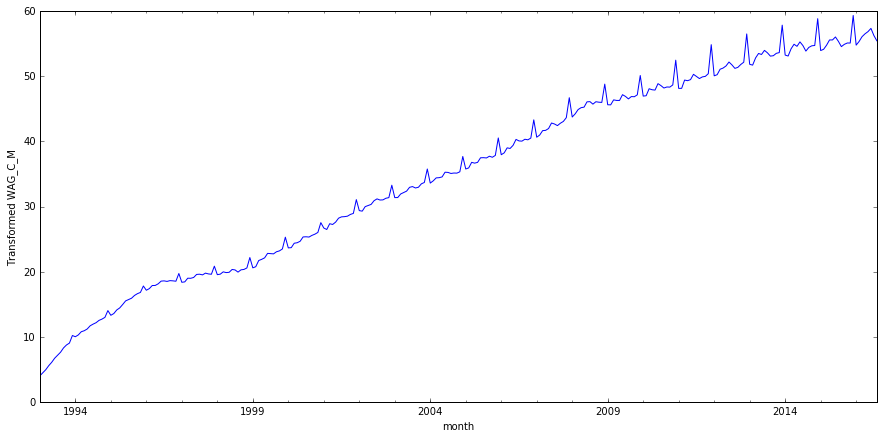

In [5]:
salary['box_WAG_C_M'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.box_WAG_C_M.plot()
plt.ylabel('Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_WAG_C_M)[1])

Критерий Дики-Фуллера принимается - выборка нестационарна.

### Стационарность

Проведем сезонное дифференцирование, проведем STL-декомпозицию, и проверим стационарность.

In [6]:
salary['box_diff_WAG']= salary.box_WAG_C_M-\
salary.box_WAG_C_M.shift(12)

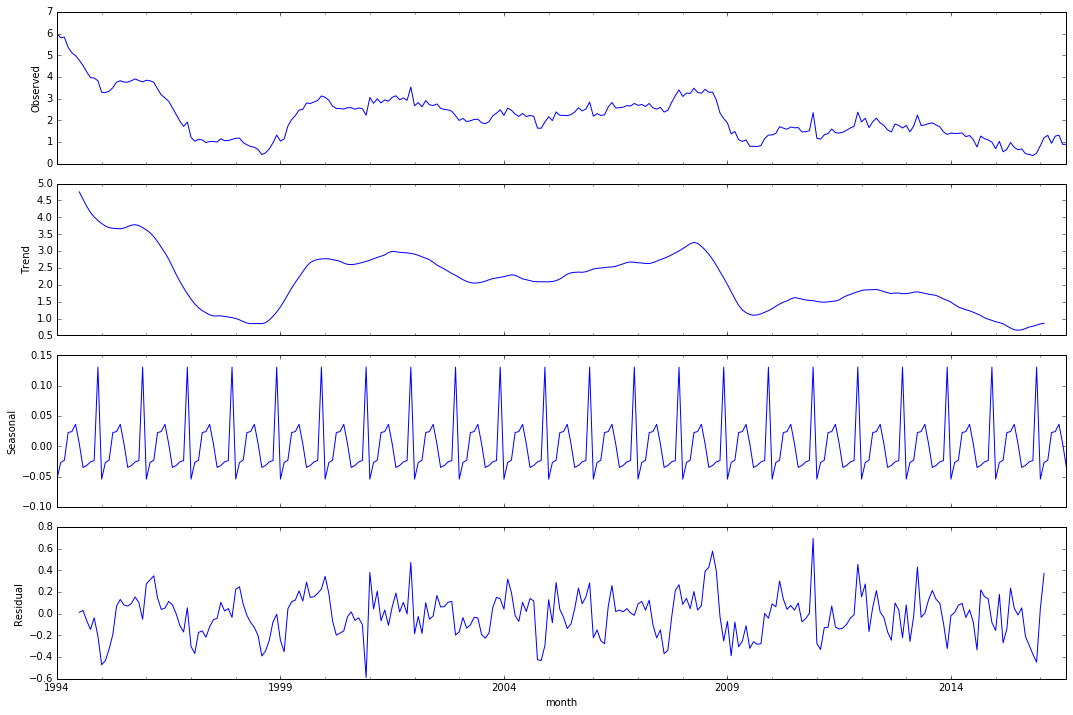

Критерий Дики-Фуллера: p=0.014697


In [7]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.box_diff_WAG[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff_WAG[12:])[1])
plt.show()

Критерий Дики-Фуллера отвергается - выборка стационарна, но на графике, мы не видем стационарности.
Поэтому проведем обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


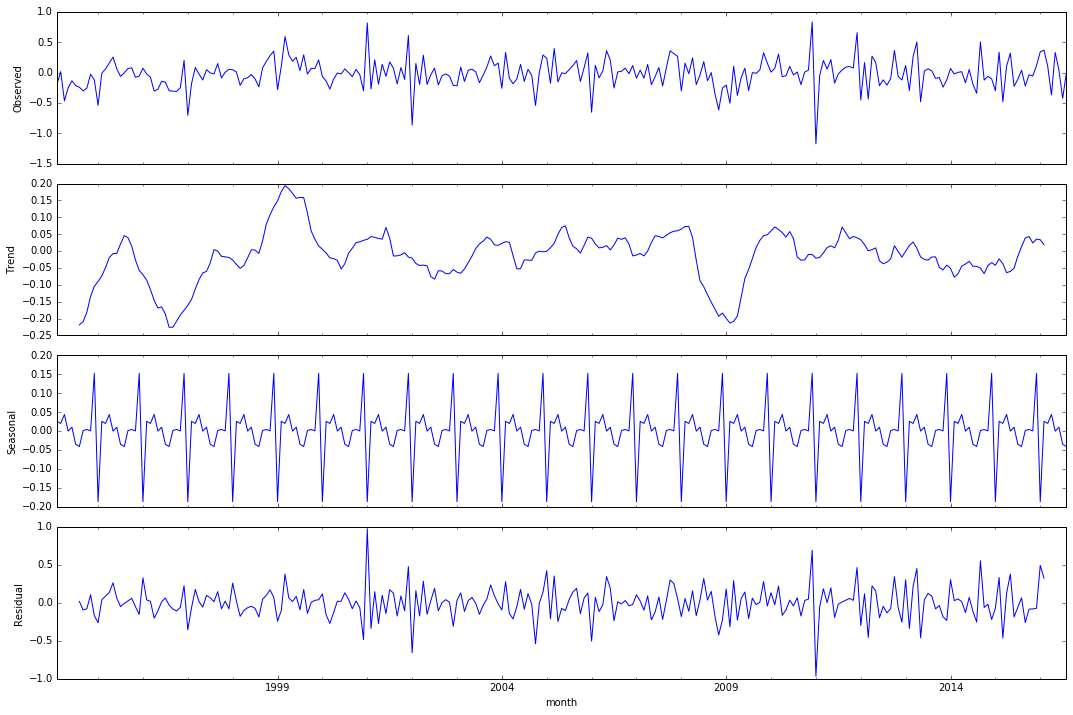

In [8]:
salary['box_diff_WAG2'] = salary.box_diff_WAG - salary.box_diff_WAG.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.box_diff_WAG2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff_WAG2[13:])[1])

Гипотеза нестационарности отвергается.

### Подбор модели 

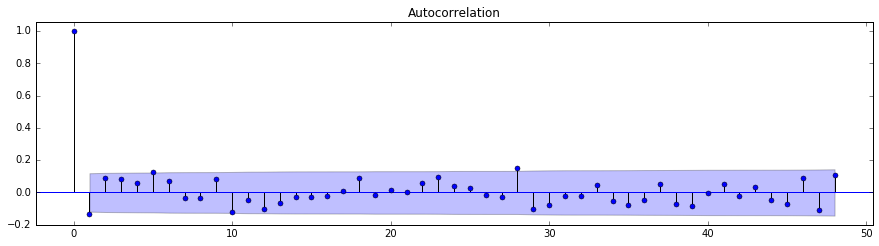

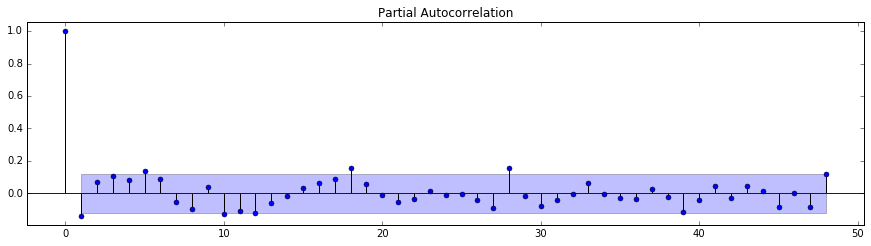

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.box_diff_WAG2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.box_diff_WAG2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q = 5, P = 4, p = 5

In [10]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = [0]

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.box_WAG_C_M, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (1, 2, 4, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 3, 0))
('wrong parameters:', (2, 2, 4, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 2, 0))
('wrong parameters:', (3, 2, 3, 0))
('wrong parameters:', (3, 2, 4, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 2, 0))
('wrong parameters:', (4, 2, 3, 0))
('wrong parameters:', (4, 2, 4, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4,

In [13]:
# import pickle

In [14]:
# with open("results","wb") as f:
#     pickle.dump(results,f)

# save_best = (best_aic,best_param)
# with open("best1","wb") as f:
#     pickle.dump(save_best,f)
# best_model.save("best model")

In [23]:
# with open("results","rb") as f:
#     results = pickle.load(f)

In [13]:
# best= None
# with open("best","rb") as f:
#     best = pickle.load(f)

Вывод моделей с наименьшими AIC

In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
130  (5, 5, 1, 0) -25.966179
131  (5, 5, 2, 0) -24.634054
129  (5, 5, 0, 0) -22.893847
132  (5, 5, 3, 0) -22.698480
133  (5, 5, 4, 0) -22.468936


In [26]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        box_WAG_C_M   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.901
Date:                            Sun, 26 Feb 2017   AIC                            -25.803
Time:                                    20:09:06   BIC                             17.985
Sample:                                01-01-1993   HQIC                            -8.247
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0150      4.760      0.003      0.997      -9.314       9.344
ar.L2          0.0116      3.205   

Остатки модели

Критерий Стьюдента: p=0.190020
Критерий Дики-Фуллера: p=0.000000


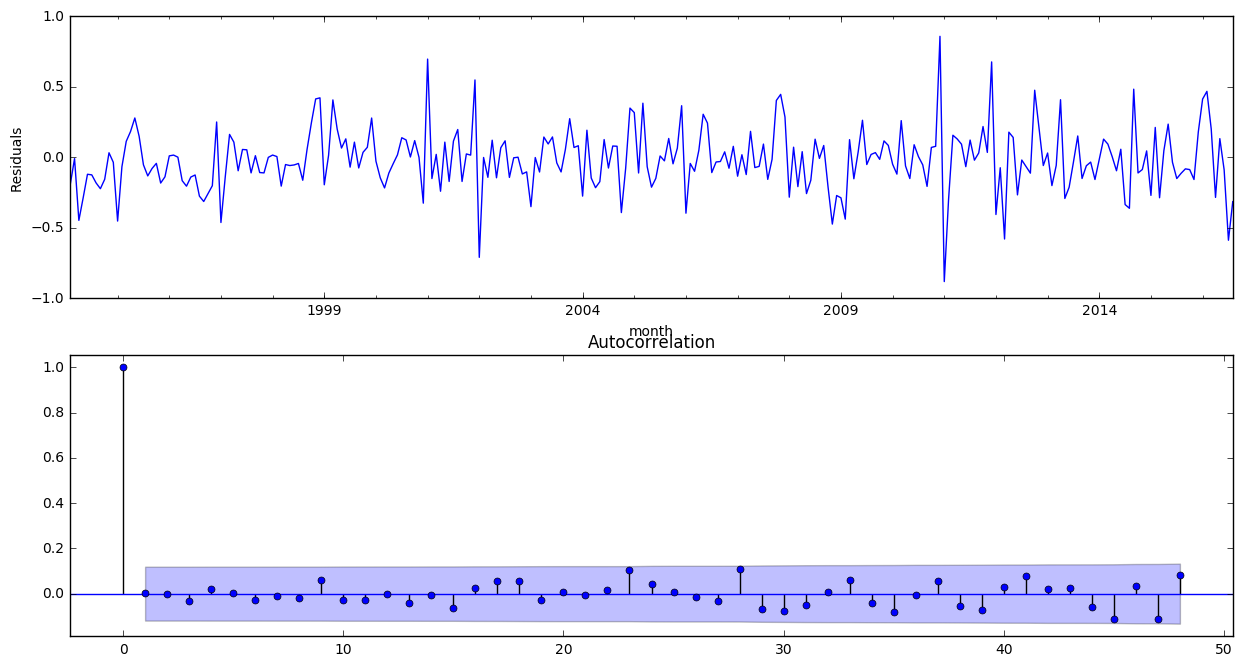

In [27]:
plt.figure(figsize(15,8))
plt.subplot(211)
model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid[13:])[1])

Остатки несмещены и стационарны

###  Сравнение модели.

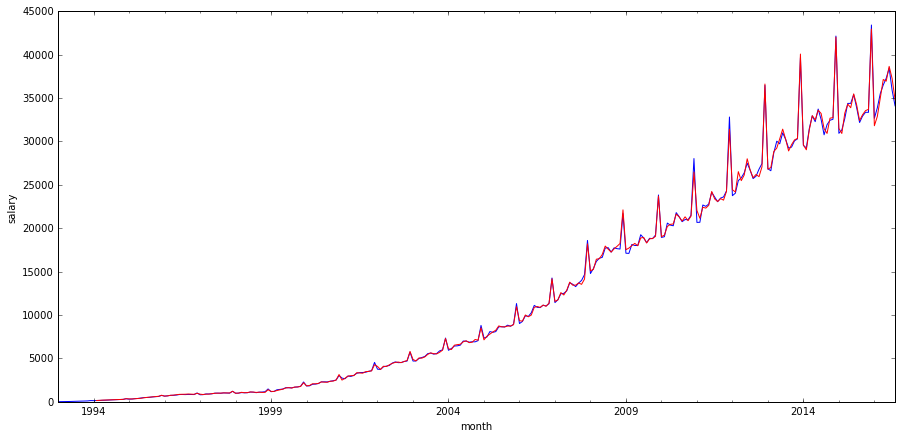

In [19]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('salary')
pylab.show()

### Прогноз 

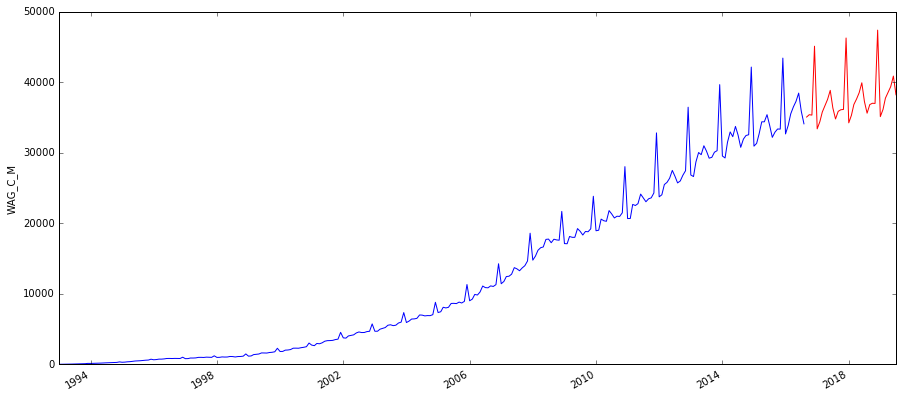

In [67]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()